In [49]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import einops

from sklearn.model_selection import train_test_split

import pandas as pd
import random


In [50]:
"""" ALL THE CONSTANT """
EPSILON = 0.3

In [51]:
df = pd.read_csv('train.csv', index_col=0)
df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
label,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
x = np.array(df.values)
y = np.array(df.index)

print(x.shape, y)

(42000, 784) [1 0 1 ... 7 6 9]


In [53]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(31500, 784) (10500, 784) (31500,) (10500,)


In [54]:
x_train_t = torch.from_numpy(x_train).type(torch.FloatTensor)
y_train_t = torch.from_numpy(y_train).type(torch.LongTensor)
x_test_t = torch.from_numpy(x_test).type(torch.FloatTensor)
y_test_t = torch.from_numpy(y_test).type(torch.LongTensor)


In [55]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, outputs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        
        self.nn = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, outputs)
        )

    def forward(self, x):
        x = einops.rearrange(x, 'n (h w) -> n h w', h=28).unsqueeze(1)
        return self.nn(self.conv(x))

net = NeuralNetwork(outputs=10)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=net.parameters(), lr=5e-4)

EPOCHS = 1_00


In [86]:
answers = []

for epoch in range(EPOCHS):
    output = net.forward(x_train_t)
    pred = output.argmax(dim=1)

    optimizer.zero_grad()
    loss = loss_fn(output, y_train_t)
    loss.backward()
    optimizer.step()

    answers.append([pred.item() for pred in (pred == y_train_t)])
    print(f'Epoch {epoch}/{EPOCHS}: {np.array(answers[-1]).mean() * 100:.2f}%\tLoss: {loss:.2f}')

Epoch 0/100: 84.45%	Loss: 0.51


KeyboardInterrupt: 

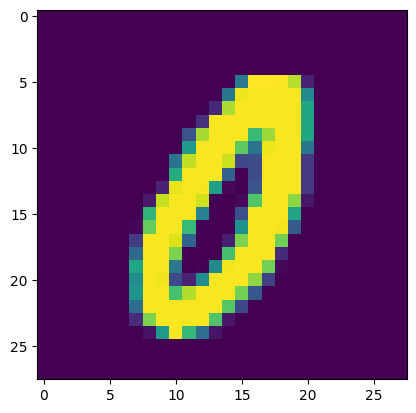

In [87]:
def test_image_N(x_test_t, net, n):
    plt.imshow(x_test_t[n].reshape((28, 28)))
    x_formated = einops.rearrange(x_test_t, 'n (h w) -> n h w', h=28).unsqueeze(1)
    pred = net.nn(torch.flatten(net.conv(x_formated[n])))
    return pred.argmax()
test_image_N(x_test_t, net, 0)
x_formated = einops.rearrange(x_test_t, 'n (h w) -> n h w', h=28).unsqueeze(1)

In [88]:
def fast_gradient_sign_method(model: NeuralNetwork, image: torch.Tensor, gradient, epsilon: float):
    """ That's the main function for white box adversarial attack """
    sign_grad = gradient.sign()
    perturbed_image = image + epsilon * sign_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [101]:
def fgsm_attack(model: NeuralNetwork, x_test_formated: torch.Tensor, y_test_t, epsilon: float):
    """ Verifier des trucs mais normalement c bon !!! """
    correct = 0
    adv_examples = []
    for x, y in zip(x_test_formated, y_test_t):
        x.requires_grad = True

        output = model.nn(torch.flatten(model.conv(x)))
        predicted_nbr = output.argmax().item()
        if predicted_nbr != y.item():
            continue

        loss = loss_fn(output, y)
        net.zero_grad()
        loss.backward()

        gradient = x.grad.data
        perturbed_data = fast_gradient_sign_method(model=model, image=x, gradient=gradient, epsilon=epsilon)

        output = model.nn(torch.flatten(model.conv(perturbed_data)))
        final_predict = output.argmax().item()
        if final_predict == y.item():
            correct += 1
        else:
            if len(adv_examples) < 5:
                print("New Example ! ==> %d and %d" % (predicted_nbr, final_predict))
                adv_examples.append((predicted_nbr, final_predict, perturbed_data))
    acc = correct / float(len(y_test_t))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(y_test_t)} = {acc}")
    return acc, adv_examples

In [115]:
answers = []

output = net.forward(x_train_t)
pred = output.argmax(dim=1)

for prediction, target in zip(pred, y_train_t):
    if prediction == target:
        answers.append(prediction)

26618 31500 0.845015873015873


In [103]:
list_examples = []
list_accuracies = []

all_epsilons = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# for eps in all_epsilons:
final_acc, adv_examples = fgsm_attack(net, x_formated, y_test_t, 0.3)
# list_examples.append(adv_examples)
# list_accuracies.append(final_acc)

New Example ! ==> 0 and 2
New Example ! ==> 1 and 2
New Example ! ==> 4 and 2
New Example ! ==> 3 and 2
New Example ! ==> 4 and 2
Epsilon: 0.3	Test Accuracy = 842 / 10500 = 0.08019047619047619


In [100]:
""" Test examples """
plt.imshow(adv_examples[4][2].detach().numpy().reshape((28, 28)))
pred = net.nn(torch.flatten(net.conv(adv_examples[4][2])))
pred.argmax()

IndexError: list index out of range